In [63]:
import importlib
import di_rnn
importlib.reload(di_rnn)

<module 'di_rnn' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\di-rnn\\di_rnn.py'>

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from di_rnn import DIRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [65]:
def preprocess_data(csv_path, m=4, n=3, freq='30min', splits=(0.6, 0.1, 0.3), horizon=1):
    print("📥 Loading and preprocessing data...")

    # === Load and resample ===
    df = pd.read_csv(csv_path, sep=';', decimal=',')
    df['ts'] = pd.to_datetime(df['ts'])
    df.set_index('ts', inplace=True)
    df = df.sort_index().resample(freq).mean()
    df['vrednost'] = df['vrednost'].interpolate()

    # === Split into train, val, test ===
    total_len = len(df)
    train_end = int(total_len * splits[0])
    val_end = train_end + int(total_len * splits[1])

    df_train = df.iloc[:train_end].copy()
    df_val   = df.iloc[train_end:val_end].copy()
    df_test  = df.iloc[val_end:].copy()

    # === Normalize ===
    print("🔢 Scaling values...")
    scaler = MinMaxScaler()
    df_train['scaled'] = scaler.fit_transform(df_train[['vrednost']])
    df_val['scaled']   = scaler.transform(df_val[['vrednost']])
    df_test['scaled']  = scaler.transform(df_test[['vrednost']])

    df_all = pd.concat([df_train, df_val, df_test])
    values = df_all['scaled']
    timestamps = values.index

    # === Prepare sequences ===
    print("🧩 Constructing input sequences...")
    min_required = max(m, n * int(pd.Timedelta('1D') / pd.to_timedelta(freq)))
    X_seq, X_per, y = [], [], []

    for idx in range(min_required, len(timestamps) - horizon):
        t = timestamps[idx]

        # Short-term input (S-RNN)
        s_start = t - m * pd.to_timedelta(freq)
        s_range = pd.date_range(start=s_start, periods=m, freq=freq)
        if not all(ts in df_all.index for ts in s_range):
            continue
        s_input = df_all.loc[s_range, 'scaled'].values.reshape(m, 1)

        # Periodic input (P-RNN)
        p_input = []
        for i in range(1, n + 1):
            prev_day_time = t - pd.Timedelta(days=i)
            if prev_day_time in df_all.index:
                p_input.append(df_all.loc[prev_day_time, 'scaled'])
            else:
                break
        if len(p_input) != n:
            continue
        p_input = np.array(p_input).reshape(n, 1)

        # Horizon target
        y_start = s_range[-1] + pd.to_timedelta(freq)
        y_range = pd.date_range(start=y_start, periods=horizon, freq=freq)
        if not all(ts in df_all.index for ts in y_range):
            continue
        y_output = df_all.loc[y_range, 'scaled'].values

        X_seq.append(s_input)
        X_per.append(p_input)
        y.append(y_output)

    # === Convert to arrays ===
    X_seq = np.array(X_seq)
    X_per = np.array(X_per)
    y = np.array(y)

    # === Final splits ===
    total_samples = len(y)
    train_end = int(total_samples * splits[0])
    val_end = train_end + int(total_samples * splits[1])

    print(f"✅ Dataset sizes → Train: {train_end}, Val: {val_end - train_end}, Test: {total_samples - val_end}")

    data = {
        'train': (X_seq[:train_end], X_per[:train_end], y[:train_end]),
        'val':   (X_seq[train_end:val_end], X_per[train_end:val_end], y[train_end:val_end]),
        'test':  (X_seq[val_end:], X_per[val_end:], y[val_end:])
    }

    return data, scaler


In [66]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        se = (y_true - y_pred) ** 2
        return torch.sqrt(torch.mean(se) + self.eps)


In [67]:
def train_dirnn(model, train_data, val_data, epochs=20, lr_rnn=0.005, lr_bpnn=0.008, device='cpu', patience=5):
    print("🚂 Starting training...")
    model = model.to(device)
    optimizer = torch.optim.Adam([
        {'params': model.s_rnn.parameters(), 'lr': lr_rnn},
        {'params': model.p_rnn.parameters(), 'lr': lr_rnn},
        {'params': model.bpnn.parameters(), 'lr': lr_bpnn},
    ])

    criterion = RMSELoss()

    X_seq_train, X_per_train, y_train = [torch.tensor(x, dtype=torch.float32).to(device) for x in train_data]
    X_seq_val, X_per_val, y_val = [torch.tensor(x, dtype=torch.float32).to(device) for x in val_data]

    print("Train target shape:", y_train.shape)
    print("Train pred shape:  ", model(X_seq_train, X_per_train).shape)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train, X_per_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_seq_val, X_per_val)
            val_loss = criterion(val_pred, y_val)

        print(f"\r📘 Epoch {epoch+1:02d}/{epochs} — \U0001F4CA Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")

        # Early stopping check
        if val_loss.item() < best_val_loss - 1e-5:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
                break

    # Restore best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model


In [68]:
print("🚀 Running DI-RNN pipeline...")
horizon = 4
data, scaler = preprocess_data('mm79158.csv', m=192, n=7, horizon=4, freq='30min')
train_data = data['train']
val_data = data['val']
test_data = data['test']

🚀 Running DI-RNN pipeline...
📥 Loading and preprocessing data...
🔢 Scaling values...
🧩 Constructing input sequences...
✅ Dataset sizes → Train: 36112, Val: 6018, Test: 18058


In [69]:
print("🧠 Initializing DIRNN model...")
model = DIRNN(seq_input_size=1, per_input_size=1, hidden_size=64, bp_hidden_size=128, dropout=0.2, horizon=horizon)

train_dirnn(model, train_data, val_data, epochs=20, lr_rnn=0.005, lr_bpnn=0.008, device='cpu')

🧠 Initializing DIRNN model...
🚂 Starting training...
Train target shape: torch.Size([36112, 4])
Train pred shape:   torch.Size([36112, 4])
📘 Epoch 01/20 — 📊 Train Loss: 0.084936 | Val Loss: 0.272129
📘 Epoch 02/20 — 📊 Train Loss: 0.292494 | Val Loss: 0.105362
📘 Epoch 03/20 — 📊 Train Loss: 0.117396 | Val Loss: 0.169177
📘 Epoch 04/20 — 📊 Train Loss: 0.147329 | Val Loss: 0.203388
📘 Epoch 05/20 — 📊 Train Loss: 0.180702 | Val Loss: 0.168535
📘 Epoch 06/20 — 📊 Train Loss: 0.146874 | Val Loss: 0.106158
📘 Epoch 07/20 — 📊 Train Loss: 0.091282 | Val Loss: 0.094394
📘 Epoch 08/20 — 📊 Train Loss: 0.102552 | Val Loss: 0.117720
📘 Epoch 09/20 — 📊 Train Loss: 0.132249 | Val Loss: 0.110191
📘 Epoch 10/20 — 📊 Train Loss: 0.123582 | Val Loss: 0.088468
📘 Epoch 11/20 — 📊 Train Loss: 0.091996 | Val Loss: 0.106326
📘 Epoch 12/20 — 📊 Train Loss: 0.091576 | Val Loss: 0.123500
📘 Epoch 13/20 — 📊 Train Loss: 0.105374 | Val Loss: 0.112986
📘 Epoch 14/20 — 📊 Train Loss: 0.096479 | Val Loss: 0.093903
📘 Epoch 15/20 — 📊 Tra

DIRNN(
  (s_rnn): FCRNN(
    (rnn1): RNN(1, 64, batch_first=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (rnn2): RNN(64, 64, batch_first=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
  (p_rnn): FCRNN(
    (rnn1): RNN(1, 64, batch_first=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (rnn2): RNN(64, 64, batch_first=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
  (bpnn): BPNN(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [70]:
torch.save(model.state_dict(), "model_weights.pth")

In [71]:
model.eval()
device = 'cpu'

X_seq_test, X_per_test, y_test = test_data
X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32).to(device)
X_per_test = torch.tensor(X_per_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

preds = []

with torch.no_grad():
    for i in range(0, len(X_seq_test)):
        seq_x = X_seq_test[i].unsqueeze(0)  # [1, m, 1]
        per_x = X_per_test[i].unsqueeze(0)  # [1, n, 1]

        pred = model(seq_x, per_x).squeeze(0).cpu().numpy()  # [horizon]
        preds.append(pred)

preds = np.array(preds)  # [samples, horizon]
true_vals = y_test.cpu().numpy()  # [samples, horizon]

# Rescale to original units
preds_rescaled = scaler.inverse_transform(preds)
true_rescaled = scaler.inverse_transform(true_vals)


In [72]:
preds_rescaled.shape, true_rescaled.shape

((18058, 4), (18058, 4))

In [73]:
preds_rescaled.max(), preds_rescaled.min()

(np.float32(1.8179677), np.float32(1.3350933))

In [74]:
mae = mean_absolute_error(true_rescaled, preds_rescaled)
mse = mean_squared_error(true_rescaled, preds_rescaled)
mape = mean_absolute_percentage_error(true_rescaled, preds_rescaled)

print("\n📊 Evaluation Metrics:")
print(f"✅ MAE:  {mae:.4f}")
print(f"✅ MSE:  {mse:.4f}")
print(f"✅ MAPE: {mape:.4f}")


📊 Evaluation Metrics:
✅ MAE:  1.4756
✅ MSE:  4.4896
✅ MAPE: 1.0068


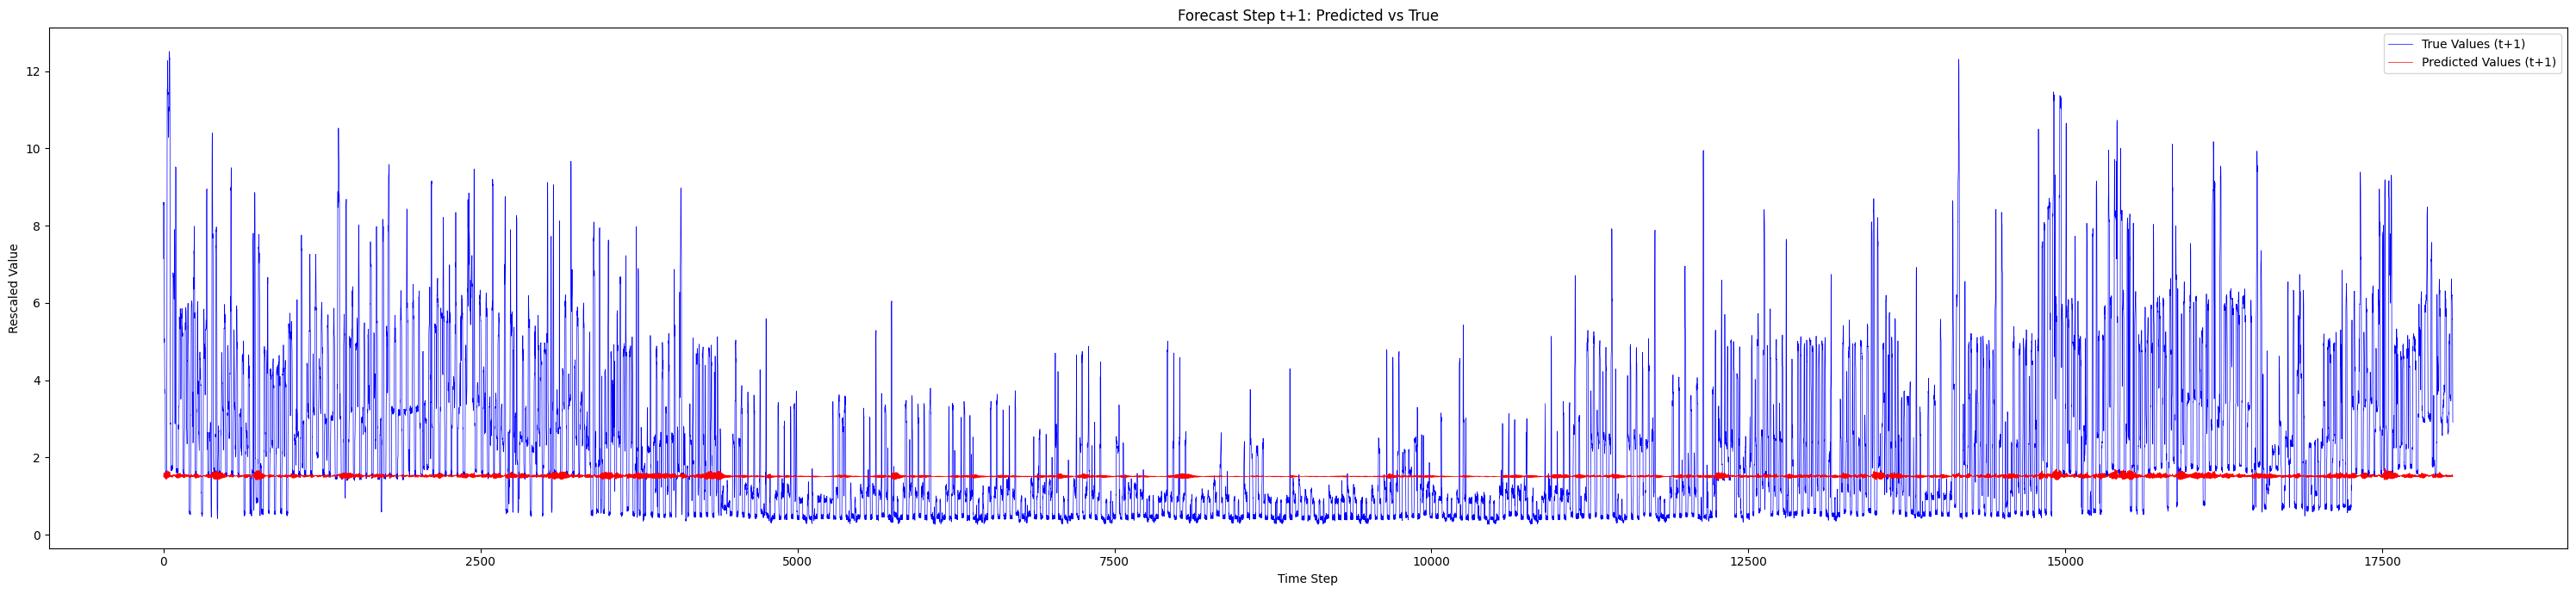

In [75]:
# Only take the first step from each prediction horizon
pred_step1 = preds_rescaled[:, 0]
true_step1 = true_rescaled[:, 0]

# Now plot 1:1 aligned forecast
plt.figure(figsize=(30, 7))
plt.plot(true_step1, color='blue', linewidth=0.5, label='True Values (t+1)')
plt.plot(pred_step1, color='red', linewidth=0.5, label='Predicted Values (t+1)')
plt.title("Forecast Step t+1: Predicted vs True")
plt.xlabel("Time Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
true_step1.shape, pred_step1.shape

((18058,), (18058,))

In [102]:
def horizon_rolling_forecast_dirnn(model, initial_seq, per_input, forecast_horizon, input_window, total_steps, scaler, device='cpu'):
    model.eval()
    preds = []
    seq = initial_seq.to(device)
    per = per_input.to(device)

    steps_done = 0

    with torch.no_grad():
        while steps_done < total_steps:
            horizon = min(forecast_horizon, total_steps - steps_done)
            y = model(seq, per).squeeze(0).cpu().numpy()[:horizon]  # [horizon]
            preds.extend(y.tolist())

            y_tensor = torch.tensor(y, dtype=torch.float32).view(1, -1, 1).to(device)
            seq = torch.cat((seq[:, horizon:, :], y_tensor), dim=1)
            steps_done += horizon

    preds = np.array(preds).reshape(-1, 1)
    return scaler.inverse_transform(preds).flatten()


In [ ]:
X_seq_train, X_per_train, y_train = train_data
X_seq_val, X_per_val, y_val = val_data
X_seq_test, X_per_test, y_test = test_data
input_window = 4
horizon = 4

input_seq = torch.tensor(X_seq_val[0:1, -input_window:], dtype=torch.float32)
input_per = torch.tensor(X_per_val[0:1], dtype=torch.float32)
total_steps = len(y_test)  # now exact

y_pred = horizon_rolling_forecast_dirnn(
    model=model,
    initial_seq=input_seq,
    per_input=input_per,
    forecast_horizon=horizon,
    input_window=input_window,
    total_steps=total_steps,
    scaler=scaler,
    device='cpu'
)


In [128]:
trues = scaler.inverse_transform(y_test)
true = trues[:, 0]

In [129]:
y_pred.shape, true.shape

((18058,), (18058,))

In [131]:
y_pred.max(), y_pred.min()

(np.float64(1.7218047868654132), np.float64(1.3130626455406844))

In [132]:
print("First 10 preds:", y_pred[:10])
print("y_pred std:", np.std(y_pred))
print("y_true std:", np.std(true))
print("y_pred min/max:", np.min(y_pred), np.max(y_pred))


First 10 preds: [1.55966544 1.71671918 1.31306265 1.5543298  1.56719559 1.72180479
 1.31950368 1.54295302 1.56720331 1.7217781 ]
y_pred std: 0.14349506110544072
y_true std: 2.014892078921037
y_pred min/max: 1.3130626455406844 1.7218047868654132


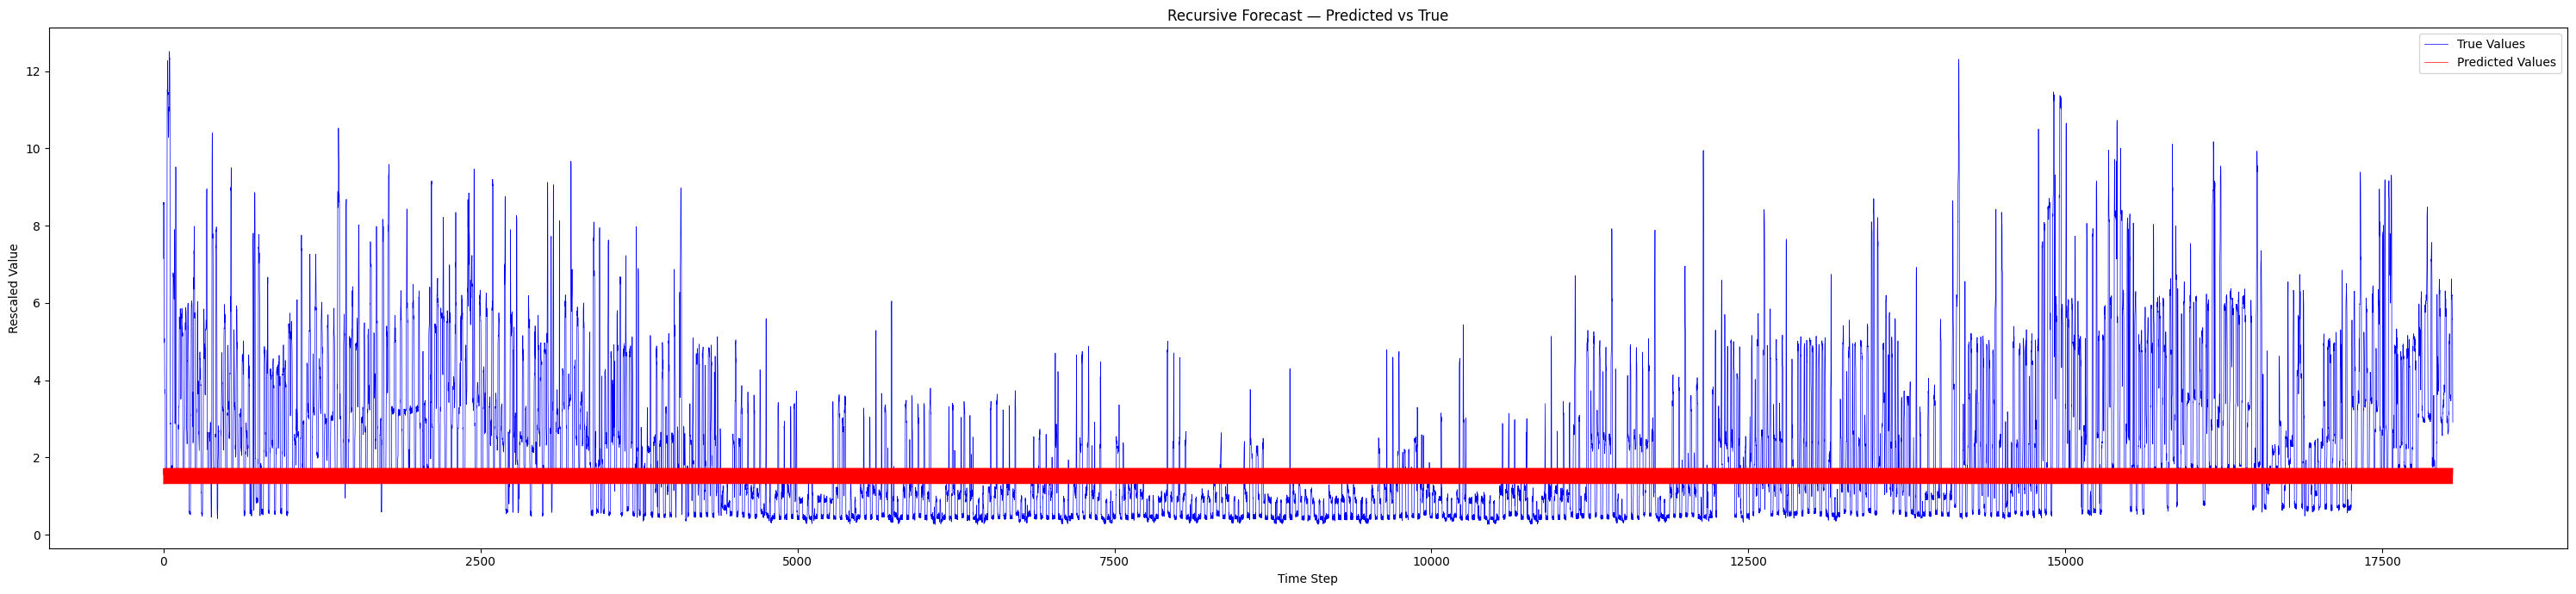

In [130]:


plt.figure(figsize=(30, 7))
plt.plot(true, color='blue', linewidth=0.5, label='True Values')
plt.plot(y_pred, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Recursive Forecast — Predicted vs True")
plt.xlabel("Time Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()


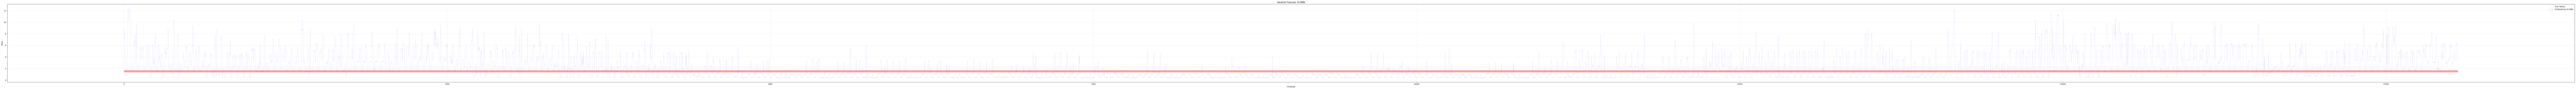

In [136]:
plt.figure(figsize=(200, 7))
plt.plot(true, color='blue', linewidth=0.3, alpha=0.4, label='True Values')
plt.plot(y_pred, color='red', linewidth=0.7, alpha=0.8, label=f'Predicted by DI-RNN')
plt.title(f"Iterative Forecast: DI-RNN")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
